<a href="https://colab.research.google.com/github/JKrusche1/PhARIS/blob/main/PhARIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phage_logo.png" height="200" align="right" style="height:200px">

##**PhARIS - v1.0**
##**Ph**age **A**ureus **R**BP **I**dentification **S**ystem

Tool for rapid detection of _Staphylococcus aureus_ phage receptor-binding proteins (RBPs) by blast homology search of a query with known _S. aureus_ RBP clusters.

Created by Janes Krusche

2023 - manuscript in preparation


In [25]:
#@title Install dependencies
#@markdown #### Install biopython, blast+ and RBP reference files
from google.colab import files
import io
import os
print("Installing biopython...")
!pip install biopython > /dev/null
print("Done")
print("Installing blast...")
!apt-get install ncbi-blast+ > /dev/null
print("Done")
if not os.path.exists("files"):
    !mkdir files
if not os.path.exists("files/RBPs_main"):
    !mkdir files/RBPs_main
if not os.path.exists("files/RBPs_rev"):
    !mkdir files/RBPs_rev
if not os.path.exists("files/blast_main"):
    !mkdir files/blast_main
if not os.path.exists("files/blast_rev"):
    !mkdir files/blast_rev
print("Downloading reference files...")
!wget -P ./files/RBPs_main https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phi11.fasta > /dev/null 2>&1
!wget -P ./files/RBPs_main https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phi12.fasta > /dev/null 2>&1
!wget -P ./files/RBPs_main https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phi13.fasta > /dev/null 2>&1
!wget -P ./files/RBPs_main https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phi12.fasta > /dev/null 2>&1
!wget -P ./files/RBPs_main https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phiBS1.fasta > /dev/null 2>&1
!wget -P ./files/RBPs_main https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phiCSA13.fasta > /dev/null 2>&1
!wget -P ./files/RBPs_main https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phiP68.fasta > /dev/null 2>&1
!wget -P ./files/RBPs_main https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phiK.fasta > /dev/null 2>&1
!wget -P ./files/RBPs_main https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phiRemus.fasta > /dev/null 2>&1
!wget -P ./files/RBPs_rev https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phiK_reversible.fasta > /dev/null 2>&1
!wget -P ./files/RBPs_rev https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phiRemus_reversible.fasta > /dev/null 2>&1
!wget -P ./files/RBPs_rev https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phi11_reversible.fasta > /dev/null 2>&1
!wget -P ./files/RBPs_rev https://raw.githubusercontent.com/JKrusche1/PhARIS/main/data/phi12_reversible.fasta > /dev/null 2>&1

clusterlist_main = {"phi12": ['phitp310-2_orf39', 'phiSMSAP5_orf23', 'phiR4_orf19', 'phiSLT_orf34', 'phiECel-2020e_orf5', 'phiECel-2020f_orf5', 'phiECel-2020h_orf5', 'phiECel-2020m_orf5', 'phi2PHSA1_orf25', 'phiLH1_orf5', 'phiSa2wa_st8_clone_WA_CAMRSA_WA5_orf35', 'phiSa2wa_st93_clone_Queensland_orf23', 'phiSa2wa_st93mssa_clone_W17S_orf23', 'phiSAP11_orf17', 'phiSAP8_orf17', 'phiSauS-IPLA35_orf7', 'phi2958PVL_proviral_orf10', 'phivB_SauS_690_orf21', 'phivB_SauS_320_orf12', 'phi47_orf5', 'phi12_orf20', 'phiPHB21_orf18', 'phiJD419_orf20', 'phiSa2wa_st121mssa_clone_K25S_orf9', 'phiSa2wa_st78_clone_WA_CAMRSA_WA2_orf8', 'phiSa2wa_st5_clone_WA_CAMRSA_WA3_orf10', 'phivB_SauS_fPfSau02_orf5', 'phiStauST398-2_orf21', 'phi4PHCISA25_orf12', 'phiSA137ruMSSAST121PVL_strain_SA137_orf34', 'phiSa2wa_st30_clone_WSPP_orf10', 'phi3A_orf30', 'phiSH-St_15644_orf30', 'phiRih21_orf21', 'phi42e_orf31', 'phiSa2wa_st72_clone_Korean_orf37', 'phi2_orf29', 'phiYMC/09/04/R1988_orf16', 'phiSa2wa_st1_orf8', 'phi7401PVL_orf18', 'phiSa2wa_st80_clone_European_orf31', 'phiP240_orf32'],
                    "phi11": ['phi11_orf38', 'phiSAP-26_orf1', 'phiUPMK_2_orf9', 'phiMR25_orf36', 'phinm2_orf11', 'phiPhiNM4-gamma4_orf9', 'phiJB_orf19', 'phiROSA_orf6', 'phinm4_orf34', 'phiSA13_orf38', 'phiSA97_orf19', 'phi71_orf22', 'phiTEM123_orf38', 'phiTEM126_orf4', 'phi92_orf37', 'phi88_orf35', 'phiETA2_orf8', 'phiSAP33_orf38', 'phiBUCT556_orf33', 'phiSAP40_orf8', 'phiBaq_Sau1_orf30', 'phiECel-2020l_orf16', 'phi96_orf13', 'phi29_orf27', 'phivB_SauS_277g_orf24', 'phinm1_orf6', 'phiECel-2020a_orf9', 'phiLorac_orf2', 'phiUPMK_1_orf79', 'phivB_SauS_775_orf36', 'phiB236_orf24', 'phiETA3_orf38', 'phivB_SauS_Mh4_orf24', 'phivB_SauS_Mh15_orf14', 'phivB_SauS_832_orf27', 'phi53_orf2', 'phi80alpha_orf7', 'phivB_SauS-SAP27_orf40', 'phiECel-2020b_orf24', 'phiECel-2020j_orf16', 'phiSA75_orf19', 'phivB_SauS_I73_orf33', 'phiECel-2020q_orf10', 'phiETA_orf24', 'phiHSA84_orf2', 'phi52A_orf20', 'phi80_orf33', 'phi85_orf33', 'phiB122_orf14', 'phi3MRA_orf30', 'phiIME1364_02_orf24', 'phivB_SauS_760_orf34', 'phiB166_orf33', 'phiStauST398-3_orf20', 'phi55_orf6', 'phiStauST398-5_orf24', 'phi69_orf16', 'phiStauST398-1_orf51', 'phivB_SauS_Mh1_orf11', 'phiMR11_orf30', 'phivB_SauS_321c_orf19', 'phivB_SauS_713_orf8', 'phivB_SauS_287_orf20', 'phiWBG8381_orf23', 'phi55-2_orf12', 'phi55-3_orf24', 'phiHenu2_orf1', 'phiSebago_orf30', 'phiDW2_orf30', 'phiX2_orf37', 'phiSA12_orf19', 'phiSP5_orf34', 'phiSP6_orf21', 'phiSauS-IPLA88_orf35'],
                    "phi13": ['phiP954_orf11', 'phivB_SauS_308_orf14', 'phitp310-3_orf33', 'phiECel-2020d_orf25', 'phitp310-1_orf10', 'phi13_orf23', 'phiSA345ruMSSAST8_orf24', 'phi23MRA_orf21', 'phi3_AJ-2017_orf22', 'phiIME1346_01_orf31', 'phiPVL_proviral_orf7', 'phiSa2wa_st22_clone_ST22-MRSA-IVc_2B_orf26', 'phiPV83_proviral_orf26', 'phivB_StaphS-IVBph354_orf16', 'phiP282_orf6', 'phiECel-2020o_orf25', 'phiECel-2020p_orf25', 'phiECel-2020k_orf15', 'phi77_orf17', 'phiSAP090B_orf14', 'phiNM3_orf27', 'phiECel-2020n_orf26', 'phiECel-2020g_orf31', 'phiSa2wa_st59_clone_Taiwan_orf26', 'phi7247PVL_orf30', 'phi5967PVL_orf30', 'phiBU01_orf30', 'phiSA1014ruMSSAST7_strain_SA1014_orf21', 'phiB_UFSM5_orf15', 'phiB_UFSM3_orf12', 'phiB_UFSM1_orf15', 'phiB_UFSM4_orf15', 'phiStauST398-4_orf11', 'phiIME1361_01_orf11', 'phiP630_orf6', 'phiSA780ruMSSAST101_orf11', 'phiJS01_orf20', 'phiSA7_orf23', 'phiSA45ruMSSAST97_orf28', 'phiSA537ruMSSAST97_orf20', 'phiN315_orf7', 'phiECel-2020i_orf16', 'phiPVL108_orf24', 'phiSa119_orf17', 'phiP1105_orf6'],
                    "phiCSA13": ['phiCSA13_orf2', 'phiBP39_orf16', 'phiS24-1_orf14'],
                    "phiP68": ['phiP68_orf7', 'phi44AHJD_orf7', 'phi66_orf1', 'phivB_SauP_EBHT_orf13', 'phiGRCS_orf11', 'phiPSa3__orf11', 'phiLSA2366_orf2', 'phiAGO1.9_orf12', 'phiAGO1.3_orf14', 'phiSLPW_orf13', 'phiPortland_orf6', 'phiS13_orf14', 'phivB_SauP-436A1_orf15', 'phiSCH111_orf13', 'phiSCH1_orf9', 'phiTSP_orf8', 'phiJPL-50_orf11', 'phiSAP-2_orf17', 'phiPabna_orf14', 'phiSA44-CTH7_orf16', 'phiSA46-CTH2_orf12', 'phiSA03-CTH2_orf3', 'phiSA30-CTH2_orf14', 'phiSA46-CTH4_orf12', 'phiSA46-CL1_orf14', 'phiSA1-CTA1_orf8'],
                    "phiBS1": ['phiSA_BS1_orf42', 'phiSA_BS2_orf47', 'phivB_SsapH-Golestan101-M_orf51'],
                    "phiRemus": ['phivB_SauM_Romulus_orf82', 'phiPM56_orf77', 'phiPM93_orf86', 'phivB_SauM_Remus_orf86', 'phivB_SauM_EW41_orf75', 'phiStau2_orf12', 'phiStAP1_orf48', 'phiSA11_orf72', 'phivB_SauM_EW22_orf16', 'phivB_SauM_EW27_orf5', 'phivB_SauM_EW15_orf65', 'phivB_SauM_EW20_orf82', 'phiqdsa001_orf76', 'phiKSAP7_orf88', 'phiKSAP11_orf88', 'phivB_Sau-RP15_orf14', 'phiLSA2308_orf83', 'phiMR003_orf85', 'phivB_SauH_DELF3_orf51'],
                    "phiK - subgroup a": ['phiK_orf39', 'phi812_isolate_host-range_mutant_K1/420_orf81', 'phiISP__orf16', 'phivB_SpsM-DS10_orf16', 'phiPM36_orf83', 'phivB_SauM_EW71_orf128', 'phivBSP-A2_orf116', 'phiHYZ21_orf74', 'phivB_SauM_EW74_orf74', 'phi812_isolate_host-range_mutant_812F1_orf13', 'phi812_isolate_host-range_mutant_K1_orf85', 'phi812_isolate_host-range_mutant_812a_orf42', 'phi812_orf80', 'phiStaph1N_orf79', 'phiA5W_orf80', 'phiJ-Sa36_orf16', 'phiP4W_orf13', 'phiIME-SA119_orf118', 'phivBSM-A1_orf62', 'phiA3R_orf46', 'phi676Z_orf14', 'phivB_SauM-A_orf43', 'phivB_SauM-C_orf76', 'phivB_SauM-D_orf85', 'phiCH1_orf55', 'phiSA5_orf84', 'phiIME-SA1_orf13', 'phiIME-SA2_orf17', 'phiIME-SA118_orf11', 'phivB_SauM-fRuSau02_orf79', 'phiSa87_orf47', 'phivB_SaS_GE1_orf76', 'phiSa30_orf77', 'phiFi200W_orf88', 'phiPM4_orf80', 'phiSAM2_orf43', 'phiSb1M_9832_orf14', 'phi812h1_orf16', 'phiSb-1_orf74', 'phiMSA6_orf82', 'phiTeam1_orf20', 'phiG1_orf16', 'phiSa83_orf18', 'phiSb1_8383_orf14', 'phiSb1M_6168_orf14', 'phipSa-3_orf15', 'phivB_SauM-515A1_orf19', 'phiPM9_orf81', 'phiPM22_orf16', 'phiPM25_orf70', 'phiPM28_orf92', 'phiPM34_orf71', 'phiPM32_orf81', 'phivB_SauH_2002_orf42', 'phiSAOMS1_orf17', 'phiMaine_orf51', 'phiSAM1_orf47', 'phiJA1_strain_Staphylococcus_aureus_CIT281189_orf77', 'phiB1_strain_Staphylococcus_aureus_DPC5246_orf81', 'phiJD007_orf83', 'phiStab21_orf93', 'phiS25-3_orf80', 'phiS25-4_orf14', 'phiGH15_orf42', 'phiqdsa002_orf46', 'phivB_SauM_0414_108_orf14', 'phivB_Sau_CG_orf85'],
                    "phiK - subgroup b": ['phiStab20_orf90', 'phiSaGU1_orf14', 'phiSA039_orf46', 'phiMetroid_orf94', 'phivB_SauM_EW26_orf71', 'phivB_SauM_EW29_orf37', 'phivB_SauM_EW72_orf43', 'phiBT3_orf18', 'phiMCE-2014_orf48', 'phiIPLA-RODI_orf55', 'phivB_SauM_EW18_orf9'],
                    "phiK - subgroup c": ['phivB_SauH_SAP1_orf82', 'phiVB-SavM-JYL02_orf78', 'phivB_ScoM-PSC1_orf83', 'phiESa1_strain_Staphylococcus_aureus_MRSN_8383_orf16', 'phivB_SauH_IME522_orf109', 'phiHSA30_orf44', 'phiVB_SavM_JYL01_orf78', 'phiSA3_orf46', 'phiP108_orf7', 'phivB_SauM_LM12_orf93', 'phiSAP23_orf16', 'phiSA012_orf47'],
                    "phiK - subgroup d": ['phiPG-2021_2_orf92', 'phiPG-2021_9_orf46', 'phiPG-2021_87_orf92', 'phiPG-2021_38_orf66', 'phiPG-2021_35_orf62', 'phiPG-2021_29_orf65', 'phiPG-2021_18_orf53', 'phiPG-2021_10_orf37', 'phipSco-10_orf87', 'phiPG-2021_84_orf58'],
                    "phiK - subgroup e": ['phiWV_orf79', 'phivB_SauM_EW3_orf120', 'phivB_SauM_EW5_orf49', 'phivB_SauM_EW6_orf120', 'phivB_SauM_EW7_orf119', 'phivB_SauM_EW9_orf85', 'phiPG-2021_47_orf83', 'phivB_SauM_EW1_orf18', 'phivB_SauM_EW2_orf5', 'phivB_SauM_EW4_orf44', 'phivB_SauM_EW13_orf44', 'phivB_Sau_P68_orf49', 'phiPG-2021_16_orf118', 'phiPG-2021_17_orf24', 'phiPG-2021_19_orf11', 'phiPG-2021_64_orf76', 'phiPG-2021_86_orf35', 'phiPG-2021_8_orf49', 'phivB_Sau_S24_orf15', 'phivB_Sau_Clo6_orf15', 'phiStab22_orf11', 'phiStab23_orf88'],
                    "phiK - subgroup f": ['phivB_SsapH-Golestan-105-M_orf119', 'phiO1-102_orf44', 'phiB2-102_orf13'],
                    "phiK - outlier": ['phiPALS_1_orf72']}

clusterlist_rev = {"phiRemus_reversible": ['phivB_SauM_Romulus_orf49', 'phivB_SauM_Remus_orf52', 'phivB_SauM_EW41_orf41', 'phiStAP1_orf11', 'phiKSAP7_orf47', 'phiKSAP11_orf47', 'phiPM56_orf43', 'phiPM93_orf46', 'phivB_SauM_EW15_orf31', 'phiSA11_orf39', 'phivB_SauM_EW20_orf47', 'phivB_SauM_EW27_orf79', 'phivB_SauM_EW22_orf89', 'phiMR003_orf50', 'phiqdsa001_orf43', 'phiStau2_orf83', 'phiLSA2308_orf125', 'phivB_Sau-RP15_orf44', 'phivB_SauH_DELF3_orf19'],
                   "phiK_reversible - subgroup a": ['phiK_orf11', 'phivBSP-A2_orf87', 'phivB_SauM_EW71_orf98', 'phivB_SauM_EW74_orf44', 'phiHYZ21_orf28', 'phiJ-Sa36_orf84', 'phi812_isolate_host-range_mutant_K1_orf47', 'phi812_isolate_host-range_mutant_K1/420_orf50', 'phi812_isolate_host-range_mutant_812F1_orf93', 'phi812_isolate_host-range_mutant_812a_orf15', 'phivB_SpsM-DS10_orf95', 'phiPM9_orf45', 'phiSAM2_orf12', 'phiPM4_orf45', 'phiPM32_orf49', 'phiPM34_orf41', 'phiPM28_orf59', 'phiPM25_orf39', 'phivB_SauH_2002_orf12', 'phivB_SauM-515A1_orf85', 'phiSb1M_9832_orf84', 'phiSb1M_6168_orf84', 'phiSb1_8383_orf84', 'phiSb-1_orf36', 'phiISP__orf84', 'phiSa83_orf88', 'phiSA5_orf48', 'phivB_SaS_GE1_orf44', 'phiPM22_orf85', 'phipSa-3_orf83', 'phiG1_orf85', 'phiMaine_orf16', 'phiSa87_orf10', 'phiMSA6_orf48', 'phiTeam1_orf84', 'phiPM36_orf50', 'phiSa30_orf49', 'phiCH1_orf18', 'phivB_SauM-fRuSau02_orf45', 'phi812_orf52', 'phiSAOMS1_orf82', 'phiB1_strain_Staphylococcus_aureus_DPC5246_orf48', 'phiIME-SA119_orf86', 'phiIME-SA2_orf82', 'phiA5W_orf48', 'phiStaph1N_orf49', 'phiJA1_strain_Staphylococcus_aureus_CIT281189_orf44', 'phiSAM1_orf12', 'phivBSM-A1_orf129', 'phiIME-SA1_orf84', 'phiIME-SA118_orf81', 'phiStab21_orf48', 'phi676Z_orf80', 'phivB_SauM-C_orf46', 'phiP4W_orf88', 'phi812h1_orf90', 'phiA3R_orf14', 'phivB_SauM-A_orf12', 'phiJD007_orf81', 'phiFi200W_orf53', 'phivB_SauM-D_orf54', 'phiSA012_orf45', 'phiS25-4_orf77', 'phiS25-3_orf49', 'phiqdsa002_orf44', 'phiIPLA-RODI_orf53', 'phiGH15_orf40'],
                   "phiK_reversible - subgroup b": ['phiESa1_strain_Staphylococcus_aureus_MRSN_8383_orf93', 'phivB_Sau_CG_orf52', 'phiVB-SavM-JYL02_orf43', 'phivB_ScoM-PSC1_orf47', 'phivB_SauH_IME522_orf74', 'phiSAP23_orf87', 'phiHSA30_orf10', 'phiSA3_orf11', 'phivB_SauM_LM12_orf56', 'phiP108_orf82', 'phiVB_SavM_JYL01_orf43', 'phiStab20_orf51', 'phivB_SauM_0414_108_orf92', 'phivB_SauM_EW72_orf127', 'phivB_SauH_SAP1_orf50', 'phiBT3_orf85', 'phivB_SauM_EW18_orf93', 'phivB_SauM_EW26_orf48', 'phivB_SauM_EW29_orf14', 'phiSA039_orf11', 'phiMetroid_orf53', 'phiSaGU1_orf76', 'phiPG-2021_18_orf15', 'phiPG-2021_29_orf116', 'phiPG-2021_2_orf59', 'phiPG-2021_35_orf29', 'phiPG-2021_38_orf24', 'phiPG-2021_47_orf40', 'phiPG-2021_84_orf127', 'phiPG-2021_87_orf49', 'phiPG-2021_9_orf118', 'phiPG-2021_10_orf9', 'phiVTCCBPA116_orf16'],
                   "phiK_reversible - outlier": ['phiWV_orf77', 'phiMCE-2014_orf16', 'phivB_SsapH-Golestan-105-M_orf56', 'phiPALS_1_orf70'],
                   "phi11_reversible": ['phiETA3_orf21', 'phiSA97_orf9', 'phiJB_orf8', 'phi88_orf22', 'phi92_orf20', 'phinm4_orf22', 'phivB_SauS_Mh15_orf38', 'phi11_orf30', 'phiROSA_orf32', 'phiPhiNM4-gamma4_orf32', 'phiSAP40_orf37', 'phiECel-2020a_orf37', 'phivB_SauS_277g_orf9', 'phi96_orf3', 'phiSAP33_orf27', 'phivB_SauS_832_orf13', 'phiMR11_orf16', 'phivB_SauS_775_orf21', 'phiSAP-26_orf28', 'phiStauST398-3_orf9', 'phiUPMK_1_orf80', 'phivB_SauS_Mh4_orf11', 'phiECel-2020q_orf31', 'phiTEM126_orf29', 'phiTEM123_orf31', 'phiUPMK_2_orf32', 'phiB236_orf11', 'phi53_orf31', 'phi80alpha_orf38', 'phiBaq_Sau1_orf24', 'phivB_SauS-SAP27_orf25', 'phi80_orf22', 'phivB_SauS_I73_orf24', 'phi85_orf24', 'phi52A_orf7', 'phiECel-2020l_orf7', 'phi55-3_orf12', 'phi69_orf7', 'phiSebago_orf17', 'phi55-2_orf37', 'phiMR25_orf24', 'phinm2_orf38', 'phiLorac_orf32', 'phi71_orf7', 'phi29_orf17', 'phinm1_orf33', 'phiETA2_orf33', 'phi55_orf32', 'phiDW2_orf20', 'phiSauS-IPLA88_orf23', 'phi3MRA_orf19', 'phiBUCT556_orf19', 'phivB_SauS_321c_orf10', 'phivB_SauS_713_orf35', 'phiX2_orf21', 'phivB_SauS_Mh1_orf37', 'phivB_SauS_287_orf10', 'phiStauST398-1_orf35', 'phiStauST398-5_orf10', 'phiIME1364_02_orf13', 'phiWBG8381_orf10', 'phiECel-2020b_orf15', 'phiETA_orf11', 'phiB122_orf35', 'phivB_SauS_760_orf24', 'phiHenu2_orf29', 'phiB166_orf22', 'phiSA13_orf26', 'phiSA12_orf11', 'phiSP5_orf28', 'phiSP6_orf13', 'phiHSA84_orf31', 'phiSA75_orf7'],
                   "phi12_reversible": ['phitp310-2_orf29', 'phiECel-2020f_orf27', 'phi12_orf10', 'phiSa2wa_st72_clone_Korean_orf22', 'phiSa2wa_st30_clone_WSPP_orf33', 'phivB_SauS_690_orf9', 'phi3A_orf18', 'phiSa2wa_st121mssa_clone_K25S_orf31', 'phiSa2wa_st1_orf31', 'phiSA137ruMSSAST121PVL_strain_SA137_orf21', 'phi2958PVL_proviral_orf33', 'phi42e_orf23', 'phiSMSAP5_orf12', 'phiSAP8_orf6', 'phiSa2wa_st78_clone_WA_CAMRSA_WA2_orf32', 'phiSa2wa_st93mssa_clone_W17S_orf10', 'phiSa2wa_st93_clone_Queensland_orf10', 'phiSa2wa_st8_clone_WA_CAMRSA_WA5_orf21', 'phiP240_orf16', 'phiSAP11_orf42', 'phi2PHSA1_orf6', 'phiECel-2020m_orf29', 'phivB_SauS_fPfSau02_orf31', 'phiSLT_orf27', 'phiECel-2020e_orf28', 'phiECel-2020h_orf28', 'phiSauS-IPLA35_orf33', 'phi4PHCISA25_orf39', 'phiStauST398-2_orf9', 'phiJD419_orf8', 'phiSa2wa_st80_clone_European_orf21', 'phiSa2wa_st5_clone_WA_CAMRSA_WA3_orf35', 'phiPHB21_orf6', 'phivB_SauS_320_orf35', 'phiR4_orf6', 'phiLH1_orf28', 'phiSH-St_15644_orf16', 'phiYMC/09/04/R1988_orf27', 'phi2_orf19', 'phiRih21_orf11', 'phi7401PVL_orf7']}

FACS_values = {"phiCSA13": [2.93, 163, 298, 147.67, 46.33, 1.79],
               "phiP68": [2.64, 2.04, 451, 1.63, 29.68, 1.8],
               "phi11": [9.727, 675.7, 278.3, 666.3, 250.3, 2.190],
               "phi12": [2.61, 5.2, 332.67, 4.77, 334, 2.53],
               "phi13": [2.57, 345.67, 324, 352, 216, 1.69],
               "phiBS1": [2.16, 2.71, 1.91, 2.5, 1.87, 328.67],
               "phiK": [15.03, 256.25, 270.5, 274.75, 129.03, 304.33],
               "phiPG2021-10": [2.38, 2.33, 351.67, 2.21, 1.94, 398.67],
               "phiPG2021-17": [2.49, 335.33, 204, 312.33, 2.09, 540.33],
               "phiSA012": [2.29, 3.83, 111.17, 3.33, 1.9, 207],
               "phiStab20": [2.43, 2.24, 127.33, 2.07, 1.9, 112.03],
               "phiK_reversible": [0, 39148.6, 99204.4, 42606.6, 152045.2, 23804],
               "phiPG2021-10_reversible": [0, 3550.67, 573.56, -184.33, 121973.67, 17241],
               "phi11_reversible": [0, 82633, 75882.5, 36705.3, 2527.5, 12385.8],
               "phi12_reversible": [0, 123659, 29174.5, 75886, 3182.25, 13472.25]}

FACS_SEM = {'phiCSA13':[0.178, 6.944, 2.494, 9.733, 6.986, 0.02],
            'phiP68':[0.105, 0.057, 14.704, 0.0, 3.383, 0.019],
            'phi11':[1.823, 30.02, 8.090,	45.70, 33.88, 0.07024],
            'phi12':[0.144, 0.222, 15.849, 0.205, 4.546, 0.116],
            'phi13':[0.09, 23.816, 14.989, 21.741, 11.813, 0.067],
            'phiBS1':[0.066, 0.078, 0.005, 0.065, 0.116, 28.073],
            'phiK':[7.108, 12.666, 13.553, 26.534, 15.162, 13.877],
            'phiPG2021-10':[0.057, 0.057, 15.176, 0.126, 0.089, 24.767],
            'phiPG2021-17':[0.129, 19.092, 8.34, 19.416, 0.205, 35.109],
            'phiStab20':[0.151, 0.169, 19.966, 0.161, 0.048, 9.556],
            'phiSA012':[0.033, 0.222, 11.22, 0.17, 0.022, 38.87],
            'phiK_reversible':[0.0, 9006.649, 12625.797, 8837.928, 10268.082, 8743.933],
            'phiPG2021-10_reversible':[0.0, 2599.405, 5499.617, 995.307, 32673.784, 7351.879],
            'phi11_reversible': [0.0, 15773, 9564, 5819, 1617, 5563],
            'phi12_reversible': [0.0, 18839, 18774, 16226, 2851, 6581]}

RBP_defi = {'phiCSA13':["phiCSA13_orf2"],
            'phiP68':["phiP68_orf7"],
            'phi11':["phi11_orf38"],
            'phi12':["phi12_orf20"],
            'phi13':["phi13_orf23"],
            'phiBS1':["phiSA_BS1_orf42"],
            'phiK':["phiK_orf39"],
            'phiPG2021-10':["phiPG-2021_10_orf37"],
            'phiPG2021-17':["phiPG-2021_17_orf24"],
            'phiStab20':["phiStab20_orf90"],
            'phiSA012':["phiSA012_orf47"],
            'phiK_reversible':["phiK_orf11"],
            'phiPG2021-10_reversible':["phiPG-2021_10_orf9"],
            'phi11_reversible':["phi11_orf30"],
            'phi12_reversible':["phi12_orf10"]}

print("Done")

Installing biopython...
  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40702 sha256=2d397f3a7a3bbc9cd261a00bf8fe618a8fae2c7cf2c4838189f6b090b1c7e502
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf
Done
Installing blast...
Done
Done


Saving phi11.fasta to phi11 (7).fasta
File uploaded successfully.
Searching for RBP...
-----------------------------------------------------------------------------------------------------------

Primary S. aureus binding phage RBP detected

-PRIMARY RBP 1: NC_004615_orf38
-Clustered in group: phi11
-Highest sequence identity with RBP of phage phi11: 100.0%
-Overlap with main RBP of phage phi11: 100.0%
-ORFs can be found in 'files/query_db.fasta'.

>NC_004615_orf38 - length 636
MSNKLITDLSRVFDYRYVDENEYNFKLISDMLTDFNFSLEYHRNKEVFAHDGEQIKYEHL
NVTSNVSDFLTYLNGRFSNMVLGHNGDGINEVKDARVDNTGYGHKTLQDRLYHDYSTLDV
FTKKVEKAVDEHYKEYRATEYRFEPKEQEPEFITDLSPYTNAVMQSFWVDPRTKIIYMTQ
ARPGNHYMLSRLKPNGQFIDRLLVKNGGHGTHNAYRYIDGELWIYSAVLDSNKNNKFVRF
QYRTGEITYGNEMQDVMPNIFNDRYTSAIYNPVENLMIFRREYKPTERQLKNSLNFVEVR
SADDIDKGIDKVLYQMDIPMEYTSDTQPMQGITYDAGILYWYTGDSNTANPNYLQGFDIK
TKELLFKRRIDIGGVNNNFKGDFQEAEGLDMYYDLETGRKALLIGVTIGPGNNRHHSIYS
IGQRGVNQFLKNIAPQVSMTDSGGRVKPLPIQNPAYLSDITEVGHYYIYTQDTQNALDFP
LPKAFRDAGWFLDVLPGHYNGALRQVLTR

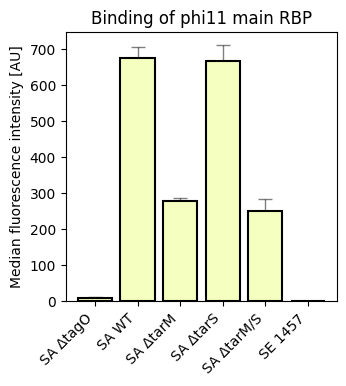


-For more information, find the closest matching RBP under https://itol.embl.de/tree/4652552332411677924980
-----------------------------------------------------------------------------------------------------------

Secondary S. aureus binding phage RBP detected

-REVERSIBLE RBP 1: NC_004615_orf30
-Clustered in group: phi11_reversible
-Highest sequence identity with RBP of phage phiETA3: 100.0%
-Overlap with main RBP of phage phiETA3: 100.0%
-ORFs can be found in 'files/query_db.fasta'.

>NC_004615_orf30 - length 607
MVVDNFSKDDNLIELQTTSQYNPVIDTNISFYESDRGTGVLNFAVTKNNRPLSISSEHVK
TSIVLKTDDYNVDRGAYISDELTIVDAINGRLQYVIPNEFLKHSGKVHAQAFFTQNGSNN
VVVERQFSFNIENDLVSGFDGITKLVYIKSIQDTIEAVGKDFNQLKQNMADTQTLIAKVN
DSATKGIQQIEIKQNEAIQAITATQTSATQAVTAEFDKIVEKEQAIFERVNEVEQQINGA
DLVKGNSTTNWQKSKLTDDYGKAIESYEQSIDSVLSAVNTSRIIHITNATDAPEKTDIGT
LEKPGQDGVDDGSSFDESTYTSSKSGVLVVYVVDNNTARATWYPDDSNDEYTKYKIYGTW
YPFYKKNDGNLTKQFVEETSNNALNQAKQYVDDKFGTTSWQQHKMTEANGQSIQVNLNNA
QGDLGYLTAGNYYATRVPDLPGSVESYEGYLSVFVKDDTNKLFNFTPY

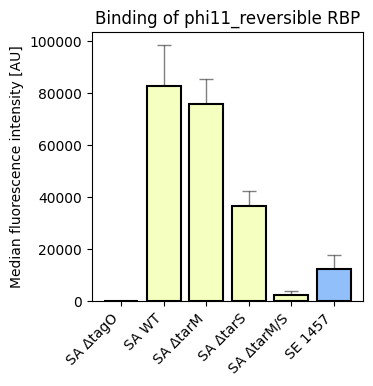


-For more information, find the closest matching RBP under https://itol.embl.de/tree/46525523312761688382866
PDF saved as output.pdf


In [26]:
#@title ### Search for S. aureus phage RBP
#@markdown Once executed, a button will appear that lets you upload your phage genome in fasta format.\
#@markdown After the upload is finished, the script will search for an _S. aureus_ binding RBP in your genome.\
#@markdown If an RBP is found, you will get the closest matching RBP of the clustering, as well as the identity to this RBP.\
#@markdown To find out where your RBP is located in the phylogenetic tree, go to the links provided and search for the closest match.\
#@markdown [Primary RBP tree](https://itol.embl.de/tree/4652552332411677924980)\
#@markdown [Secondary RBP tree](https://itol.embl.de/tree/46525523312761688382866)

#@markdown To search another genome, simply rerun this cell and upload another file.

#Import libraries
from Bio import SeqIO
import os
import glob
import pathlib
import pandas as pd
import sys
import time
import matplotlib.pyplot as plt
import numpy as np

#Upload file
# Prompt the user to upload a file
uploaded = files.upload()

# Check if any files were uploaded
if uploaded:
    # If files were uploaded, execute the following block of code
    print('File uploaded successfully.')

    # Save the uploaded file to the "files" directory with the name "genome.fasta"
    with open(os.path.join('files', 'genome.fasta'), 'wb') as f:
        # Write the contents of the uploaded file to the newly created "genome.fasta" file
        # The "next(iter(uploaded))" extracts the name of the uploaded file
        # The "uploaded[next(iter(uploaded))]" fetches the contents of the uploaded file
        f.write(uploaded[next(iter(uploaded))])
else:
    # If no files were uploaded, execute the following block of code
    print('No file uploaded.')

    # Exit the program
    sys.exit()



#Detect ORFs in query
print("Searching for RBP...")
for seq_record in SeqIO.parse("files/genome.fasta", "fasta"):
    orfseq = []
    orflen = []
    orfnr = []
    x = 0
    file = seq_record.seq
    for strand, nuc in [(+1, file), (-1, file.reverse_complement())]:
        for frame in range(3):
            length = 3 * ((len(file)-frame) // 3) #Multiple of three
            for pro in nuc[frame:frame+length].translate(11).split("*"):
                  splitlocal = pro.find('M')
                  seq_final = pro[splitlocal:]
                  if len(seq_final) >= 100:
                    x = x+1
                    orflen.append(len(seq_final))
                    seq_final = str(seq_final)
                    seq_final = '\n'.join(seq_final[i:i+60] for i in range(0, len(seq_final), 60))
                    orfseq.append(str(seq_final))
                    orfnr.append(x)
if len(orfseq) == 0:
    print("No ORFs were detected.")
    sys.exit()
else:
    with open('files/query_db.fasta', 'w') as f:
        for i in range(len(orfseq)):
            f.write(">" + seq_record.id + "_orf" + str(orfnr[i]) + " - length " + str(orflen[i]) + "\n")
            f.write(orfseq[i] + "\n")

#Create database and blast with known RBPs
!makeblastdb -in files/query_db.fasta -dbtype prot -out files/protein_db > /dev/null;
for file in glob.glob("files/RBPs_main/*.fasta"):
        filename = file.replace("files/RBPs_main/","")
        filename = filename.replace(".fasta","")
        !blastp -query {file} -db files/protein_db -outfmt 6 -out files/blast_main/{filename}_blast.txt
for file in glob.glob("files/RBPs_rev/*.fasta"):
        filename = file.replace("files/RBPs_rev/","")
        filename = filename.replace(".fasta","")
        !blastp -query {file} -db files/protein_db -outfmt 6 -out files/blast_rev/{filename}_blast.txt

#Extract primary RBP from blast
result = pd.DataFrame()
for filename in glob.glob("files/blast_main/*_blast.txt"):
    df = pd.read_csv(filename, sep='\t', header = None)
    df.columns = ['query acc.ver', 'subject', 'identity', 'alignment length', 'mismatches', 'gap opens', 'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score']
    df["lengthper"] = df["alignment length"]/df['alignment length'].iloc[0]
    df = df[df.lengthper >=0.8]
    df = df[df.identity > 80]
    df.loc[df['lengthper'] > 1, 'lengthper'] = 1
    df = df.reset_index(drop=True)

    if df.empty:
      x = x
    else:
      result = pd.concat([result, df.sort_values('identity', ascending=False).head(1)], ignore_index=True)
      finaldf = df

# Graph settings
x_labels = ['SA ΔtagO', 'SA WT', 'SA ΔtarM', 'SA ΔtarS', 'SA ΔtarM/S', 'SE 1457']
colors = ['#F4FFC0', '#F4FFC0', '#F4FFC0', '#F4FFC0', '#F4FFC0', '#90BFF9']

#Visualize primary RBP
print("-----------------------------------------------------------------------------------------------------------")
RBPs_found = 0
if result.empty:
    print("No primary S. aureus binding phage RBP could be detected.")
else:
    RBPs_found = 1
    print("\nPrimary S. aureus binding phage RBP detected\n")
    for i in range(len(result)):
      phageRBP = result.iloc[i]["query acc.ver"]
      for name, lst in clusterlist_main.items():
        for item in lst:
            if phageRBP in item:
                cluster = name
      if "phiK " in cluster:
        if "subgroup a" in cluster:
          graphname = "phiK"
        elif "subgroup b" in cluster:
          graphname = "phiStab20"
        elif "subgroup c" in cluster:
          graphname = "phiSA012"
        elif "subgroup d" in cluster:
          graphname = "phiPG2021-10"
        elif "subgroup e" in cluster:
          graphname = "phiPG2021-17"
        elif "subgroup f" in cluster:
          graphname = "not tested"
        elif "outlier" in cluster:
          graphname = "not tested"
      else:
        graphname = cluster
      if graphname in RBP_defi:
        RBP_match = RBP_defi[graphname][0]
        match_row = finaldf.loc[finaldf['query acc.ver'] == RBP_match]
        identity_value = match_row.iloc[0]['identity']
      print("-\033[1mPRIMARY RBP " + str(i+1) + ": " + result.iloc[i]["subject"] + "\033[0m")
      print("-Clustered in group: \033[1m" + cluster + "\033[0m")
      print("-Highest sequence identity with RBP of phage \033[4m\033[1m" + result.iloc[i]["query acc.ver"].split("_orf")[0] + "\033[0m: " + str(result.iloc[i]["identity"]) + "%")
      print("-Overlap with main RBP of phage " + result.iloc[i]["query acc.ver"].split("_orf")[0] + ": " + str(result.iloc[i]["lengthper"]*100) + "%")
      print("-ORFs can be found in 'files/query_db.fasta'.\n")
      with open('files/query_db.fasta', 'r') as f:
          query_db = f.read()
          query_db = query_db.split(result.iloc[0]["subject"])[-1]
          query_db = query_db.split(">")[0]
          print(">" + result.iloc[0]["subject"] + query_db + "\n")
      y_values = [0,0,0,0,0,0]
      if graphname in FACS_values:
          print("\033[1mIdentity of RBP " + result.iloc[i]["subject"] + " with RBP of " + graphname + ": " + str(np.round(identity_value,2)) + "%\033[0m")
          y_values = FACS_values[graphname]
          sem = FACS_SEM[graphname]
          ind = np.arange(6)
          # Create the bar chart with the desired size
          fig, ax = plt.subplots(figsize=(3.5, 3.5))

          # Create the bar plot
          ax.bar(x_labels, y_values, align='center', alpha=1, ecolor="k", color=colors, edgecolor="k",
                 linewidth=1.5)
          plotline1, caplines1, barlinecols1 = ax.errorbar(ind, y_values, yerr=sem, lolims=True,
                                                           capsize = 0, ls='None', color="k", alpha=0.5,
                                                           linewidth=1)

          caplines1[0].set_marker('_')
          caplines1[0].set_markersize(10)
          # Set the axis labels and title
          ax.set_ylim(bottom=0)
          ax.set_xlabel('')
          ax.set_ylabel('Median fluorescence intensity [AU]')
          ax.set_title('Binding of ' + graphname + " main RBP")
          ax.set_xticks(range(len(x_labels)))
          ax.set_xticklabels(x_labels, rotation=45, ha='right')
      else:
          print(f"No binding pattern available for {graphname}")
      plt.show()
      print(f"\n-For more information, find the closest matching RBP under {'https://itol.embl.de/tree/4652552332411677924980'}")
if 'df' in locals():
    del df
if 'result' in locals():
    del result

#Extract secondary RBP from blast
result = pd.DataFrame()
for filename in glob.glob("files/blast_rev/*_blast.txt"):
    df = pd.read_csv(filename, sep='\t', header = None)
    df.columns = ['query acc.ver', 'subject', 'identity', 'alignment length', 'mismatches', 'gap opens', 'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score']
    df["lengthper"] = df["alignment length"]/df['alignment length'].iloc[0]
    df = df[df.lengthper >=0.8]
    df = df[df.identity > 80]
    df.loc[df['lengthper'] > 1, 'lengthper'] = 1
    df = df.reset_index(drop=True)
    if df.empty:
      x = x
    else:
      result = pd.concat([result, df.sort_values('identity', ascending=False).head(1)], ignore_index=True)
      finaldf = df

#Visualize secondary RBP
print("-----------------------------------------------------------------------------------------------------------")
if result.empty:
    print("No secondary S. aureus binding phage RBP could be detected.")
    if RBPs_found == 0:
      print("-----------------------------------------------------------------------------------------------------------")
      print("\033[1mNo RBPs found. This phage might not be able to infect S. aureus or is an outliers that does not cluster.\033[0m")
else:
    print("\nSecondary S. aureus binding phage RBP detected\n")
    for i in range(len(result)):
      phageRBP = result.iloc[i]["query acc.ver"]
      for name, lst in clusterlist_rev.items():
        for item in lst:
            if phageRBP in item:
                cluster = name
      if "phiK_reversible " in cluster:
        if "subgroup a" in cluster:
          graphname = "phiK_reversible"
        elif "subgroup b" in cluster:
          graphname = "phiPG2021-10_reversible"
        elif "outlier" in cluster:
          graphname = "not tested"
      else:
        graphname = cluster
      if graphname in RBP_defi:
        RBP_match = RBP_defi[graphname][0]
        match_row = finaldf.loc[finaldf['query acc.ver'] == RBP_match]
        identity_value = match_row.iloc[0]['identity']
      print("-\033[1mREVERSIBLE RBP " + str(i+1) + ": " + result.iloc[i]["subject"] + "\033[0m")
      print("-Clustered in group: \033[1m" + cluster + "\033[0m")
      print("-Highest sequence identity with RBP of phage \033[4m\033[1m" + result.iloc[i]["query acc.ver"]
            .split("_orf")[0] + "\033[0m: " + str(result.iloc[i]["identity"]) + "%")
      print("-Overlap with main RBP of phage " + result.iloc[i]["query acc.ver"].split("_orf")[0] + ": " + str(result.iloc[i]["lengthper"]*100) + "%")
      print("-ORFs can be found in 'files/query_db.fasta'.\n")

      with open('files/query_db.fasta', 'r') as f:
          query_db = f.read()
          query_db = query_db.split(result.iloc[0]["subject"])[-1]
          query_db = query_db.split(">")[0]
          print(">" + result.iloc[0]["subject"] + query_db + "\n")
      y_values = [0,0,0,0,0,0]
      if graphname in FACS_values:
          print("\033[1mIdentity of RBP " + result.iloc[i]["subject"] + " with RBP of " + graphname + ":" + str(np.round(identity_value,2)) + "%\033[0m")
          y_values = FACS_values[graphname]
          sem = FACS_SEM[graphname]
          ind = np.arange(6)
          # Create the bar chart with the desired size
          fig, ax = plt.subplots(figsize=(3.5, 3.5))

          # Create the bar plot
          ax.bar(x_labels, y_values, align='center', alpha=1, ecolor="k", color=colors, edgecolor="k",
                 linewidth=1.5)
          plotline1, caplines1, barlinecols1 = ax.errorbar(ind, y_values, yerr=sem, lolims=True,
                                                           capsize = 0, ls='None', color="k", alpha=0.5,
                                                           linewidth=1)

          caplines1[0].set_marker('_')
          caplines1[0].set_markersize(10)
          # Set the axis labels and title
          ax.set_ylim(bottom=0)
          ax.set_xlabel('')
          ax.set_ylabel('Median fluorescence intensity [AU]')
          ax.set_title('Binding of ' + graphname + " RBP")
          ax.set_xticks(range(len(x_labels)))
          ax.set_xticklabels(x_labels, rotation=45, ha='right')
      else:
          print(f"No binding pattern available for {graphname}")
      plt.show()
      print(f"\n-For more information, find the closest matching RBP under {'https://itol.embl.de/tree/46525523312761688382866'}")